In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import scipy.stats as stats


/Users/shahzadiaiman/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import os

path = '/Users/shahzadiaiman/Downloads/statoil-iceberg-classifier-challenge'
print(os.listdir(path))


['.DS_Store', 'test.json', 'train.json', 'sample_submission.csv']


In [3]:
# Load data

train_df = pd.read_json('/Users/shahzadiaiman/Downloads/statoil-iceberg-classifier-challenge/train.json')
test_df = pd.read_json('/Users/shahzadiaiman/Downloads/statoil-iceberg-classifier-challenge/test.json')

sample_df = pd.read_csv('/Users/shahzadiaiman/Downloads/statoil-iceberg-classifier-challenge/sample_submission.csv')

print(train_df.head())
print(sample_df.head())

         id                                             band_1  \
0  dfd5f913  [-27.878361, -27.15416, -28.668615, -29.537971...   
1  e25388fd  [-12.242375, -14.920305, -14.920363, -12.66633...   
2  58b2aaa0  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  4cfc3a18  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  271f93f4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2 inc_angle  is_iceberg  
0  [-27.154118, -29.537888, -31.0306, -32.190483,...   43.9239           0  
1  [-31.506321, -27.984554, -26.645678, -23.76760...   38.1562           0  
2  [-24.870956, -24.092632, -20.653963, -19.41104...   45.2859           1  
3  [-27.889421, -27.519794, -27.165262, -29.10350...   43.8306           0  
4  [-27.206915, -30.259186, -30.259186, -23.16495...   35.6256           0  
         id  is_iceberg
0  5941774d         0.5
1  4023181e         0.5
2  b20200e4         0.5
3  e7f018bb         0.5
4  4371c8c3         0

In [4]:
# Feature engineering

import numpy as np

# For training data
def extract_features(df):
    band1 = np.array([np.array(b).reshape(75,75) for b in df['band_1']])
    band2 = np.array([np.array(b).reshape(75,75) for b in df['band_2']])
    
    # Downsampled pixels
    band1_flat = np.array([b[::2,::2].flatten() for b in band1])
    band2_flat = np.array([b[::2,::2].flatten() for b in band2])
    
    # Statistical features
    def stats_features(band):
        mean = band.mean(axis=(1,2))
        std = band.std(axis=(1,2))
        min_ = band.min(axis=(1,2))
        max_ = band.max(axis=(1,2))
        median = np.median(band, axis=(1,2))
        skew = stats.skew(band.reshape(band.shape[0], -1), axis=1)
        kurt = stats.kurtosis(band.reshape(band.shape[0], -1), axis=1)
        range_ = max_ - min_
        return np.column_stack([mean, std, min_, max_, median, skew, kurt, range_])
    
    band1_stats = stats_features(band1)
    band2_stats = stats_features(band2)
    
    # Combine features
    X_features = np.concatenate([band1_flat, band2_flat, band1_stats, band2_stats], axis=1)
    
    # Incidence angle
    incidence = pd.to_numeric(df['inc_angle'].replace('na', np.nan), errors='coerce')
    incidence = incidence.fillna(incidence.mean()).values.reshape(-1,1)
    
    X = np.concatenate([X_features, incidence], axis=1)
    return X

# Prepare data
X = extract_features(train_df)
y = train_df['is_iceberg'].values

/var/folders/n5/rjbcg9dj5zv3ghm5byyll9700000gn/T/ipykernel_16222/3405231461.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incidence = pd.to_numeric(df['inc_angle'].replace('na', np.nan), errors='coerce')


In [5]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Training shape: (1283, 2905)
Validation shape: (321, 2905)


In [7]:
# Build the model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,487,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,809 (6.32 MB)

 Trainable params: 1,654,017 (6.31 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [8]:
#Train the model

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5452 - loss: 2.2987 - val_accuracy: 0.5888 - val_loss: 2.5692
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5849 - loss: 2.2360 - val_accuracy: 0.6355 - val_loss: 2.0937
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5627 - loss: 2.2030 - val_accuracy: 0.6417 - val_loss: 2.0946
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6581 - loss: 2.0450 - val_accuracy: 0.6636 - val_loss: 1.9620
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7012 - loss: 1.9386 - val_accuracy: 0.6729 - val_loss: 1.8682
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7409 - loss: 1.8337 - val_accuracy: 0.7477 - val_loss: 1.7546
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7654 - loss: 1.7189 - val_accuracy: 0.7290 - val_loss: 1.7331
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7981 - loss: 1.6681 - val_accuracy: 0.7259 - va

In [9]:
# Evaluate accuracy and recall

# Predict on validation set
y_val_probs = model.predict(X_val).flatten()
y_val_pred = (y_val_probs >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Recall: {recall:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Validation Accuracy: 0.7850
Validation Recall: 0.7152


In [10]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)
best_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # F1 max
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold:.3f}")

# Recalculate predictions
y_val_pred = (y_val_probs >= best_threshold).astype(int)


Best threshold: 0.312


In [11]:
# Recalculate predictions using the optimal threshold
y_val_pred = (y_val_probs >= best_threshold).astype(int)

# Compute metrics again

accuracy = accuracy_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()

tn_rate = tn / (tn + fp) * 100
tp_rate = tp / (tp + fn) * 100

print(f"\nUpdated metrics with threshold {best_threshold:.3f}:")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"True Negative Rate (TNR): {tn_rate:.2f}%")
print(f"True Positive Rate (TPR): {tp_rate:.2f}%")



Updated metrics with threshold 0.312:
Validation Accuracy: 0.8069
Validation Recall: 0.8675
True Negative Rate (TNR): 75.29%
True Positive Rate (TPR): 86.75%


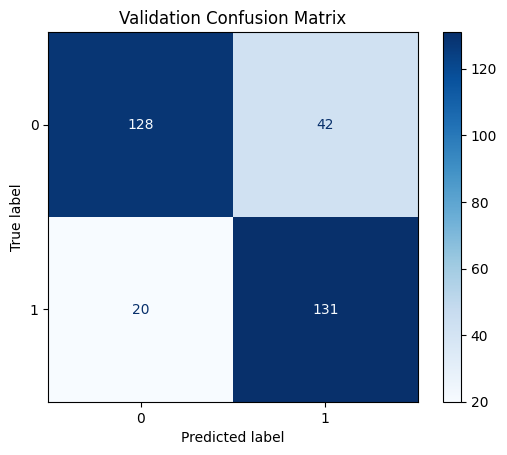

In [12]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

Note:  1 if it is an iceberg, and 0 if it is a ship


A TP is when you predicted “iceberg” (positive) and the actual label is iceberg

A TN is when you predicted “ship” (negative) and the actual label is ship.